Implement a three-hidden-layer feedforward neural network for multi-class classification using a synthetic dataset with five distinct classes.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

np.random.seed(123)
features, labels = make_blobs(n_samples=1200, centers=5, n_features=8, cluster_std=2.0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(labels.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)

def softmax(x):
    exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

class CustomNN:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.params = {}
        h1, h2, h3 = hidden_sizes
        self.params['W1'] = np.random.randn(input_size, h1) * 0.1
        self.params['b1'] = np.zeros((1, h1))
        self.params['W2'] = np.random.randn(h1, h2) * 0.1
        self.params['b2'] = np.zeros((1, h2))
        self.params['W3'] = np.random.randn(h2, h3) * 0.1
        self.params['b3'] = np.zeros((1, h3))
        self.params['W4'] = np.random.randn(h3, output_size) * 0.1
        self.params['b4'] = np.zeros((1, output_size))

    def forward(self, X):
        self.cache = {}
        self.cache['Z1'] = X @ self.params['W1'] + self.params['b1']
        self.cache['A1'] = sigmoid(self.cache['Z1'])
        self.cache['Z2'] = self.cache['A1'] @ self.params['W2'] + self.params['b2']
        self.cache['A2'] = sigmoid(self.cache['Z2'])
        self.cache['Z3'] = self.cache['A2'] @ self.params['W3'] + self.params['b3']
        self.cache['A3'] = sigmoid(self.cache['Z3'])
        self.cache['Z4'] = self.cache['A3'] @ self.params['W4'] + self.params['b4']
        self.output = softmax(self.cache['Z4'])
        return self.output

    def backward(self, X, y_true, lr=0.01):
        m = X.shape[0]
        delta4 = self.output - y_true
        dW4 = self.cache['A3'].T @ delta4 / m
        db4 = np.sum(delta4, axis=0, keepdims=True) / m
        delta3 = (delta4 @ self.params['W4'].T) * sigmoid_deriv(self.cache['A3'])
        dW3 = self.cache['A2'].T @ delta3 / m
        db3 = np.sum(delta3, axis=0, keepdims=True) / m
        delta2 = (delta3 @ self.params['W3'].T) * sigmoid_deriv(self.cache['A2'])
        dW2 = self.cache['A1'].T @ delta2 / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m
        delta1 = (delta2 @ self.params['W2'].T) * sigmoid_deriv(self.cache['A1'])
        dW1 = X.T @ delta1 / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m

        for param, grad in zip(['W1','b1','W2','b2','W3','b3','W4','b4'], [dW1, db1, dW2, db2, dW3, db3, dW4, db4]):
            self.params[param] -= lr * grad

    def train(self, X, y, epochs=1000, lr=0.01):
        loss_history = []
        for epoch in range(epochs):
            self.forward(X)
            loss = cross_entropy_loss(self.output, y)
            loss_history.append(loss)
            self.backward(X, y, lr)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
        return loss_history

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

In [18]:
model = CustomNN(input_size=8, hidden_sizes=(64, 48, 24), output_size=5)
losses = model.train(X_train, y_train, epochs=1000, lr=0.02)

Epoch 0: Loss = 1.6230
Epoch 100: Loss = 1.6083
Epoch 200: Loss = 1.6081
Epoch 300: Loss = 1.6080
Epoch 400: Loss = 1.6078
Epoch 500: Loss = 1.6077
Epoch 600: Loss = 1.6076
Epoch 700: Loss = 1.6074
Epoch 800: Loss = 1.6073
Epoch 900: Loss = 1.6072


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

predictions = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_test_labels, predictions))
print("\nClassification Report:")
print(classification_report(y_test_labels, predictions, zero_division=0))

Accuracy: 0.1638888888888889

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00        72
           2       0.16      1.00      0.28        59
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        79

    accuracy                           0.16       360
   macro avg       0.03      0.20      0.06       360
weighted avg       0.03      0.16      0.05       360



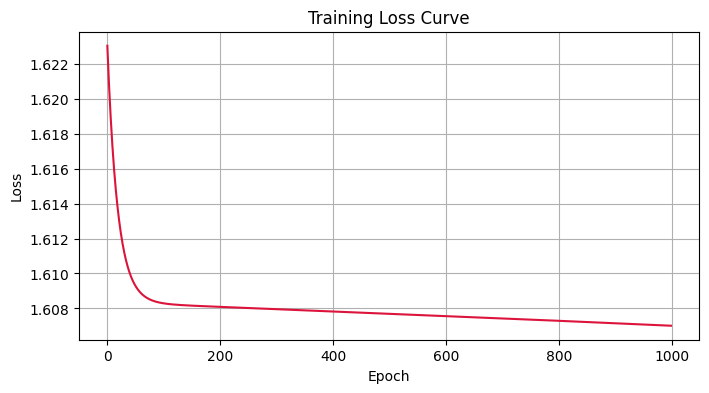

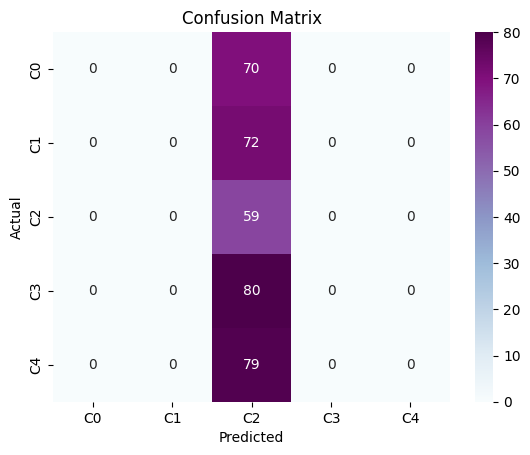

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(losses, color='crimson')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=[f"C{i}" for i in range(5)], yticklabels=[f"C{i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()